## Training a sentiment analysis classifier based on supervised machine learning algorithms

In [1]:
import string

import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.svm import SVC

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
stop_words = set(stopwords.words('spanish'))

In [4]:
def tokenizer(text):
    tt = TweetTokenizer()
    return tt.tokenize(text)

### Loading labeled tweets

In [5]:
# Dataset loaded from: https://docs.google.com/spreadsheets/d/11_E2ngsEOyTQwbwVVRHY5urzFF95BQCV/edit#gid=1788161364
tweets_df = pd.read_csv('./data/tweets_labeled.csv', sep = ',')

In [6]:
tweets_df.shape

(296, 2)

In [7]:
tweets_df.head()

,full_text,sentiment
0,@Nata_Salud @Sandrag69 @AndresMejiaV ¡Hola Natalia! Te invitamos a descubrir tu #MatchPresidencial aquí: https://t.co/0E1tZKypTK,neutral
1,@supershadai @Registraduria Quien o que institución en Colombia atiende los reclamos al fraude electoral?\r\nPorque no suspender a al registrador que ya la defeco en las elecciones de senado y camara.\r\nHay una desconfianza general en cuanto a las presidenciales.\r\nEstán provocando una respuesta violenta.,negative
2,@BOLIBAR2 @AndresPastrana_ @santiagoangelp Un poco tarde con las elecciones encima… mal para Colombia,negative
3,"No encontraron otra alternativa que llenar de miedo a Colombia, utilizan sus paramilitares para ganar elecciones. Es ahora o nunca @petrogustavo",positive
4,"@BOLIBAR2 @CNE_COLOMBIA @AndresPastrana_ Aquí no va a pasar nada, y petro de va a robar las elecciones presidenciales y el país",negative


In [8]:
tweets_df['sentiment'].value_counts(dropna = False, normalize = True)

negative    0.668919
neutral     0.270270
positive    0.060811
Name: sentiment, dtype: float64

### Leaving out unlabeled texts, this data is not useful for training or validating a supervised model

In [9]:
# Removing  unlabeled tweets
tweets_labeled_df = tweets_df.loc[tweets_df['sentiment'].notnull()]

In [10]:
tweets_labeled_df.shape

(296, 2)

In [11]:
tweets_unlabeled_df = tweets_df.loc[tweets_df['sentiment'].isnull()]

In [12]:
tweets_unlabeled_df.shape

(0, 2)

In [13]:
# Scenario 3: Treating neutral as positive classes
tweets_labeled_df['sentiment'] = tweets_labeled_df['sentiment'].replace({'neutral':'positive'})

### Splitting train and test datasets

In [14]:
X_train, X_test, y_train, y_test = train_test_split(tweets_labeled_df['full_text'], tweets_labeled_df['sentiment'], test_size = 0.2, stratify = tweets_labeled_df['sentiment'], random_state = 1)


In [15]:
X_train.shape

(236,)

In [16]:
pd.Series(y_train).value_counts(normalize = True)

negative    0.669492
positive    0.330508
Name: sentiment, dtype: float64

In [17]:
X_test.shape

(60,)

In [18]:
pd.Series(y_test).value_counts(normalize = True)

negative    0.666667
positive    0.333333
Name: sentiment, dtype: float64

### Vectorizing texts

<table>
    <tbody>
        <tr>
            <td>
                <h4>Bag of Words</h4>
                <img src="imgs/bow.png" style="width: 500px;">
            </td>
            <td>
                <h4>TF-IDF</h4>
                <img src="imgs/tf-idf.png" style="width: 500px;">
            </td>
        </tr>
    </tbody>
</table>

In [19]:
bow = CountVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [20]:
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [21]:
X_bow = bow.fit_transform(X_train)

In [22]:
X_tfidf = tfidf.fit_transform(X_train)

### Training and evaluating a model using BOW

In [23]:
model = SVC(kernel='poly', degree=4, gamma='scale')

In [24]:
model.fit(X_bow, y_train)

SVC(degree=4, kernel='poly')

In [25]:
y_train_bow_predict = model.predict(X_bow)
y_test_bow_predict = model.predict(bow.transform(X_test))

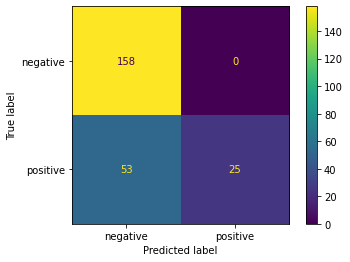

In [26]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

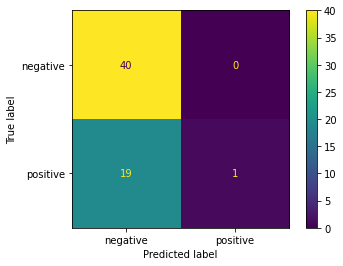

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [28]:
# Metrics calculation for more than two classes
print('Precision:', precision_score(y_test, y_test_bow_predict, average = None))
print('Recall:', recall_score(y_test, y_test_bow_predict, average = None))
print('F1:', f1_score(y_test, y_test_bow_predict, average = None))

Precision: [0.6779661 1.       ]
Recall: [1.   0.05]
F1: [0.80808081 0.0952381 ]


### Training and evaluating a model using TF-IDF

In [29]:
model = SVC(kernel='poly', degree=4, gamma='scale')

In [30]:
model.fit(X_tfidf, y_train)

SVC(degree=4, kernel='poly')

In [31]:
y_train_tfidf_predict = model.predict(X_tfidf)
y_test_tfidf_predict = model.predict(bow.transform(X_test))

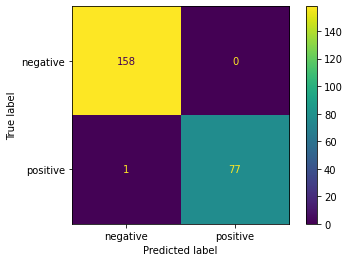

In [32]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

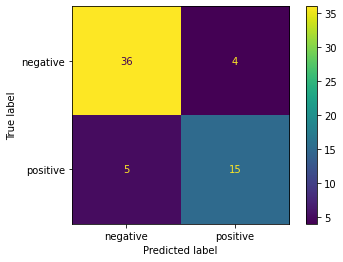

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [34]:
# Metrics calculation for more than two classes
print('Precision:', precision_score(y_test, y_test_tfidf_predict, average = None))
print('Recall:', recall_score(y_test, y_test_tfidf_predict, average = None))
print('F1:', f1_score(y_test, y_test_tfidf_predict, average = None))

Precision: [0.87804878 0.78947368]
Recall: [0.9  0.75]
F1: [0.88888889 0.76923077]


### How interpret the results?

### Analyzing errors Bag of Words

In [35]:
error_df1 = pd.concat(
    [ pd.concat([X_test, y_test ], axis = 1).reset_index(),
    pd.Series(y_test_bow_predict) ]
, axis = 1).rename(columns = { 'sentiment': 'actual', 0: 'predicted' })

error_df1.drop('index', inplace = True, axis = 1)

In [36]:
error_df1.shape

(60, 3)

In [37]:
error_df1.loc[error_df1['actual'] != error_df1['predicted']].head(20)

,full_text,actual,predicted
6,#EnVivo Match presidencial: descubra su candidato ideal para las elecciones presidenciales en Colombia\r\nhttps://t.co/wR0HWCjnIQ https://t.co/Do4GVNQ6SO,positive,negative
7,"¿Y Si gana @petrogustavo? ¡Colombia 🇨🇴escucha!\r\n\r\nOtro clip de la emisión de #EncuentroLibertario🗽, con @CarlosAChacon, del @ICPColombia, y a @Juan__Angel__, del @libertariocol sobre las elecciones presidenciales colombianas.\r\n\r\nVea el video completo aquí: https://t.co/FFZeuyo62H https://t.co/Lyvy7pOnnd",positive,negative
10,🇨🇴 La calificadora de riesgos le mantuvo a #Colombia su calificación crediticia confiando en que su estabilidad macroeconómica se mantendrá una vez elija nuevo presidente: https://t.co/Ajf3jcFhdX,positive,negative
15,¿Quién es ese candidato que defiende sus mismas ideas? 🧐\r\n\r\n¡Descubralo en nuestro #MatchPresidencial! Una herramienta que creamos junto a @cifrasyconcepto y @elespectador para que el próximo 29 de mayo salga a votar por su candidato ideal. \r\n\r\nhttps://t.co/x1nxEYCfD7 https://t.co/78W2DyWiKB,positive,negative
17,Señores. @PGN_COL\r\n\r\nEl país reclama elecciones transparentes en primera vuelta presidencial el 29 de mayo.\r\n\r\nOpinión. @PGN_COL @CNE_COLOMBIA @moecolombia https://t.co/ceSkMa0f3W,positive,negative
19,"El Consejo Nacional Electoral @CNE_COLOMBIA envió concepto jurídico al Tribunal de Cundinamarca en el que pide que no se suspenda al registrador Alexander Vega. \r\n\r\nSegún el organismo electoral, las elecciones legislativas cumplieron con todas las garantías de transparencia.",positive,negative
21,"El Tribunal Administrativo de Cundinamarca negó la solicitud de suspensión provisional del Registrador Nacional, Alexander Vega. Sin embargo, decretó unas medidas cautelares para garantizar las elecciones. | A 23 días para la elección presidencial en Colombia, opine. https://t.co/KNA8oitIEa",positive,negative
22,(Elecciones Colombia: ¿qué muestran las más recientes encuestas presidenciales?) publicado en https://t.co/XJ7xIbDAXM - https://t.co/kBmI6ABhaM https://t.co/iDU3rbQpNu,positive,negative
24,"Hoy en viernes de entrevista😎 nuestro cofundador Carlos Jaramillo conversó con nosotros sobre emprendimiento, elecciones 2022 y consejos para los que quieren empezar su empresa en Colombia. Léela completa aquí 👉https://t.co/uTedwy2rSf #blog #emprendedor #emprendimiento",positive,negative
32,Haga “match” con la elección presidencial | EL ESPECTADOR https://t.co/LD3WviiaEz,positive,negative


### Analyzing errors TF-IDF

In [38]:
error_df2 = pd.concat(
    [ pd.concat([X_test, y_test ], axis = 1).reset_index(),
    pd.Series(y_test_tfidf_predict) ]
, axis = 1).rename(columns = { 'sentiment': 'actual', 0: 'predicted' })

error_df2.drop('index', inplace = True, axis = 1)

In [39]:
error_df2.shape

(60, 3)

In [40]:
error_df2.loc[error_df2['actual'] != error_df2['predicted']].head(20)

,full_text,actual,predicted
2,"Esto está increíble. Saca la conversación de los personalismos y pone el debate sobre las ideas y la afinidad ideológica, gente. Entrénle a este match político de @fundacionFESCOL. Espectacular @Saruy 👏🏾👏🏾👏🏾👏🏾 https://t.co/0tyZdteu0Z",negative,positive
3,"El Registrador Alexander Vega y el @CNE_COLOMBIA Insisten en meterle al pueblo colombiano el gol este 29 de mayo, están desesperados por entregarle el poder a la izquierda en Colombia. https://t.co/fPyKsxf40K",negative,positive
7,"¿Y Si gana @petrogustavo? ¡Colombia 🇨🇴escucha!\r\n\r\nOtro clip de la emisión de #EncuentroLibertario🗽, con @CarlosAChacon, del @ICPColombia, y a @Juan__Angel__, del @libertariocol sobre las elecciones presidenciales colombianas.\r\n\r\nVea el video completo aquí: https://t.co/FFZeuyo62H https://t.co/Lyvy7pOnnd",positive,negative
10,🇨🇴 La calificadora de riesgos le mantuvo a #Colombia su calificación crediticia confiando en que su estabilidad macroeconómica se mantendrá una vez elija nuevo presidente: https://t.co/Ajf3jcFhdX,positive,negative
21,"El Tribunal Administrativo de Cundinamarca negó la solicitud de suspensión provisional del Registrador Nacional, Alexander Vega. Sin embargo, decretó unas medidas cautelares para garantizar las elecciones. | A 23 días para la elección presidencial en Colombia, opine. https://t.co/KNA8oitIEa",positive,negative
24,"Hoy en viernes de entrevista😎 nuestro cofundador Carlos Jaramillo conversó con nosotros sobre emprendimiento, elecciones 2022 y consejos para los que quieren empezar su empresa en Colombia. Léela completa aquí 👉https://t.co/uTedwy2rSf #blog #emprendedor #emprendimiento",positive,negative
33,"Viví de cerca el CAMBIO de Venezuela.\r\n\r\nFue el pais más rico de América Latina, hoy su economía está destruida.\r\n\r\nA punta de decretos acaban connlas empresas y la que sobrevive la expropian.\r\n\r\nColombia es anticomunista y lo demostraremos en las próximas elecciones.",negative,positive
37,"El Registrador Alexander Vega y el @CNE_COLOMBIA Insisten en meterle al pueblo colombiano el gol este 29 de mayo, están desesperados por entregarle el poder a la izquierda en Colombia. https://t.co/fPyKsxf40K",negative,positive
45,"@GustavoBolivar Debieran inventar algo diferente están igual que Chávez y Maduro cada vez que vienen elecciones inventaba guerras con Colombia, que había intereses en matarlo y ustedes igualito inventan enfermedades, atentados etc, etc.",positive,negative
